# Visualise Imputed Broadcast Tracking Data
We would like to showcase how StatsPerform's imputed broadcast tracking data can be visualized. 

In [1]:
import sys 
from os import getcwd, chdir
from os.path import join

chdir('..')
sys.path.append(join(getcwd(), 'src'))

# 1. Load game
First, a game containing the imputed broadcast tracking data must be read. This file should be placed in **data/{BASE_PATH}.parquet**, where **BASE_PATH** can be changed. 

In [2]:
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from tracking_animator.basic_plot import BasicPlot
from tracking_animator.visualiser import SoccerAxes
from tracking_animator.interactive_animator import InteractiveAnimation
from tracking_animator.interactive_controller import InteractiveController
import numpy as np
import wget

GAME_URL = "https://www.dropbox.com/scl/fi/pwikdpqb7y270mtrp5vww/2378386.parquet?rlkey=z8z9ppaik9gaxx0zxrc0ydb23&dl=1"
wget.download(GAME_URL, "sample_game.parquet")
full_df = pd.read_parquet('sample_game.parquet')

100% [........................................................................] 15935453 / 15935453

# 2. Extracts all datasources
We then extract the event and imputed data from the merged file. Then, we extract a data frame which specifies the event stream (which has no associated tracking data).

The tracking data contains the following columns:
+ '*current_phase* ': the current period
+ '*timeelapsed* ': the time in seconds of the current period.
+ '*frame_count* ': unique identifier for each frame.
+ '*player_id* ': unique agent identifier.
+ '*team_id* ': indicates home(=1)/away(=2); team_id 4 is the ball.
+ '*jersey_no* ': jersey number of the player.
+ '*x* ': event's x-location in Opta coordinates.
+ '*y* ': event's y-location in Opta coordinates.
+ '*event_description* ': event's text description.
+ '*typeId* ': event's unique identifier.
+ '*stoppage* ': indicates whether the game is stopped.
+ '*is_ball* ': indicates whether agent is the ball or not.
+ '*goalkeeper*': indicates whether agent is goalkeeper.
+ '*pred_x* ': Imputed x-coordinate on the pitch; pitch coordinates in [-52.5, 52.5]
+ '*pred_y* ': Imputed y-coordinate on the pitch; pitch coordinates in [-34, 34]

In [3]:
def get_datasource(trajectory_columns):    
    df = full_df.copy()
    df[['empty_x', 'empty_y']] = np.NaN
    df[['full_x', 'full_y']] = df[trajectory_columns] if trajectory_columns is not None else np.NaN
    return df


pred = get_datasource(['pred_x', 'pred_y'])
event = get_datasource(None)

# 3. Animation i: Imputed Tracking Animation
We first animate the imputed tracking data. In this animation we also have:
- Slider: for scrubbing through video.
- Segment dropdown: for changing between the 1st and 2nd half.
- Game-State Information: whether play is stopped, current half and time.
- Event selector: the event stream is also displayed in tabular form. Clicking on an event jumps the tracking data to that timestep. 

<IPython.core.display.Javascript object>


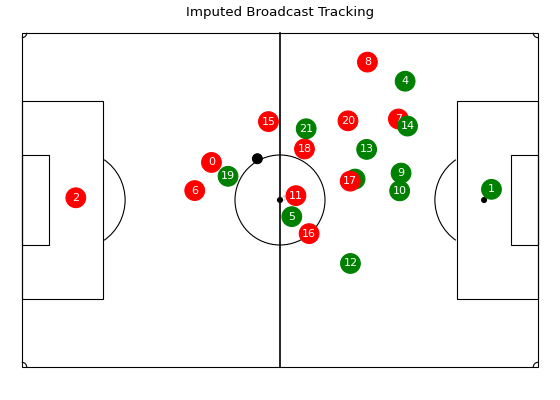

In [4]:
%matplotlib notebook

base_fig = plt.figure(figsize=(7, 5))

plts = []

base_fig.add_subplot(111, axes_class=SoccerAxes, margin=2, padding=2).draw_pitch()

base_fig.tight_layout() 

pred[['full_x', 'full_y']] = pred[['pred_x', 'pred_y']]

plots = [
    BasicPlot(ax=base_fig.axes[0], df=pred.copy(), 
              title="Imputed Broadcast Tracking", 
              is_draw_events=False, 
              is_draw_tail=False,
              is_draw_polygon=False,
              is_draw_speed=False,
              color_map={1:'red', 2: 'green', 4: 'black'})
]

i = InteractiveAnimation(plots, pred.copy(), base_fig, frame_rate=5)
controller = InteractiveController(i, pred.copy())
controller.create_animation()